In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer

In [2]:
train_data = pd.read_csv('traininingdata.txt', sep=';')
test_data = pd.read_csv('testdata.txt', sep=';')

In [3]:
train_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,divorced,secondary,no,-78,yes,yes,cellular,29,jul,10,23,-1,0,unknown,no
1,50,management,married,tertiary,no,106,yes,no,unknown,15,may,388,2,-1,0,unknown,no
2,47,admin.,married,secondary,no,407,yes,no,unknown,5,jun,67,12,-1,0,unknown,no
3,39,admin.,divorced,secondary,no,952,yes,no,unknown,16,jun,62,1,-1,0,unknown,no
4,30,management,single,tertiary,no,364,no,no,cellular,30,apr,306,2,-1,0,unknown,yes


# 1. Preprcessing Data

## 1.1 split job into 4 groups based on label

In [4]:
sort_job=train_data.groupby('job').apply(lambda x:sum(x.y=='yes')/len(x)).sort_values(axis=0)
low_level=tuple(sort_job[:4].index.values)
mid_level=tuple(sort_job[4:8].index.values)
advanced_level=tuple(sort_job[8:10].index.values)
high_level=tuple(sort_job[10:].index.values)

In [5]:
train_data.replace({'job': {**{i:1 for i in low_level}, **{i:2 for i in mid_level}, **{i:3 for i in advanced_level}, **{i:4 for i in high_level}}}, inplace=True)
test_data.replace({'job': {**{i:1 for i in low_level}, **{i:2 for i in mid_level}, **{i:3 for i in advanced_level}, **{i:4 for i in high_level}}}, inplace=True)

## 1.2 fill 999 for -1 in pdays

In [6]:
train_data.replace({'pdays':{-1:999}}, inplace=True)

In [7]:
## 1.3 Label Encode education, month, poutcome as well as label

In [8]:
train_data.poutcome.unique()

array(['unknown', 'other', 'failure', 'success'], dtype=object)

In [9]:
train_data.groupby('poutcome').apply(lambda x: sum(x.y == 'yes') / len(x))

poutcome
failure    0.123765
other      0.169685
success    0.653146
unknown    0.091584
dtype: float64

In [10]:
month_dict = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
label_dict = {'yes': 1, 'no': 0}
education_dict = {'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3}
poutcome_dict = {'unknown': 0, 'other': 2, 'failure': 1, 'success': 3}

train_data['month'] = train_data.month.apply(lambda x: month_dict[x])
train_data['y'] = train_data.y.apply(lambda x: label_dict[x])
train_data['education'] = train_data.education.apply(lambda x: education_dict[x])
train_data['poutcome'] = train_data.poutcome.apply(lambda x: poutcome_dict[x])

test_data['month'] = test_data.month.apply(lambda x: month_dict[x])
test_data['y'] = test_data.y.apply(lambda x: label_dict[x])
test_data['education'] = test_data.education.apply(lambda x: education_dict[x])
test_data['poutcome'] = test_data.poutcome.apply(lambda x: poutcome_dict[x])


In [11]:
train_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,2,divorced,2,no,-78,yes,yes,cellular,29,7,10,23,999,0,0,0
1,50,3,married,3,no,106,yes,no,unknown,15,5,388,2,999,0,0,0
2,47,2,married,2,no,407,yes,no,unknown,5,6,67,12,999,0,0,0
3,39,2,divorced,2,no,952,yes,no,unknown,16,6,62,1,999,0,0,0
4,30,3,single,3,no,364,no,no,cellular,30,4,306,2,999,0,0,1


## 1.4 one-hoe encode marital, default, housing, loan and contact

In [12]:
!pip freeze | findstr "sci"

scikit-image==0.18.3
scikit-learn==1.1.2
scikit-learn-intelex==2021.20210714.120553
scipy @ file:///C:/ci/scipy_1630606917240/work


In [13]:
# one-hot encode job, default, housing, loan, contact
transformer = make_column_transformer((OneHotEncoder(drop='if_binary'), ['marital', 'default', 'housing', 'loan', 'contact']), remainder = 'passthrough').fit(train_data)
train_transformed = transformer.transform(train_data)
test_transformed = transformer.transform(test_data)

train_transformed = pd.DataFrame(train_transformed, columns = transformer.get_feature_names_out())
train_transformed.columns = [i.split('__')[-1] for i in train_transformed.columns]
test_transformed = pd.DataFrame(test_transformed, columns = transformer.get_feature_names_out())
test_transformed.columns = [i.split('__')[-1] for i in test_transformed.columns]

In [14]:
test_transformed.head()

,marital_divorced,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_cellular,contact_telephone,contact_unknown,age,...,education,balance,day,month,duration,campaign,pdays,previous,poutcome,y
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,48.0,...,3.0,468.0,14.0,5.0,220.0,1.0,-1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,31.0,...,3.0,10215.0,22.0,8.0,139.0,2.0,-1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,45.0,...,1.0,900.0,9.0,6.0,213.0,1.0,-1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,58.0,...,1.0,1231.0,20.0,6.0,21.0,3.0,-1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,35.0,...,3.0,5301.0,21.0,11.0,937.0,2.0,-1.0,0.0,0.0,1.0


## 1.5 standard-scale all numerical columns

In [15]:
numerical_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
# for all other columns, cast to int after scaling
int_features = [i for i in train_transformed.columns if i not in numerical_features]

scaler = make_column_transformer((MinMaxScaler(), numerical_features), remainder='passthrough').fit(train_transformed)

train_transformed = pd.DataFrame(scaler.transform(train_transformed), columns = scaler.get_feature_names_out())
train_transformed.columns = [i.split('__')[-1] for i in train_transformed.columns]

test_transformed = pd.DataFrame(scaler.transform(test_transformed), columns = scaler.get_feature_names_out())
test_transformed.columns = [i.split('__')[-1] for i in test_transformed.columns]

## 1.6 cast remaining columns to int

In [16]:
train_transformed = train_transformed.astype({i:'int' for i in int_features})
test_transformed = test_transformed.astype({i:'int' for i in int_features})

In [17]:
train_transformed.head()

,marital_divorced,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_cellular,contact_telephone,contact_unknown,age,...,education,balance,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,0,0,0,1,1,1,0,0,42.0,...,2,-78.0,29,7,10.0,23.0,999.0,0.0,0,0
1,0,1,0,0,1,0,0,0,1,50.0,...,3,106.0,15,5,388.0,2.0,999.0,0.0,0,0
2,0,1,0,0,1,0,0,0,1,47.0,...,2,407.0,5,6,67.0,12.0,999.0,0.0,0,0
3,1,0,0,0,1,0,0,0,1,39.0,...,2,952.0,16,6,62.0,1.0,999.0,0.0,0,0
4,0,0,1,0,0,0,1,0,0,30.0,...,3,364.0,30,4,306.0,2.0,999.0,0.0,0,1


## 1.7 split data

In [18]:
xtrain, xval, ytrain, yval = train_test_split(train_transformed.drop('y', axis = 1), train_transformed['y'], test_size=0.2)
xtest, ytest = test_transformed.drop('y', axis = 1), test_transformed['y']

## 1.8 Downsample Train data to n2p = 5

In [19]:
positive_count = sum(ytrain == 1)
negative_indexes = ytrain[ytrain == 0].sample(n = positive_count * 5).index
all_indexes = negative_indexes.append(ytrain[ytrain == 1].index)


In [20]:
xtrain_sampled = xtrain.loc[all_indexes,:]
ytrain_sampled = ytrain.loc[all_indexes]

# 1.9 Over Sample traning data using SMOTE

In [21]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy=0.6,random_state=5101)
xtrain_SMOTE, ytrain_SMOTE = smote.fit_resample(xtrain, ytrain)

# 2 Fit Models

## 2.1 Random Forest

### 2.1.1 train on unsampled data

In [22]:
classifier = RandomForestClassifier(random_state=5101, n_estimators=400, oob_score=True)
classifier.fit(xtrain, ytrain)

RandomForestClassifier(n_estimators=400, oob_score=True, random_state=5101)

In [23]:
new_proba = classifier.predict_proba(xtest)
new_prediction = (new_proba[:, 1] >= 0.4).astype('int')

In [24]:
print('precision:', precision_score(ytest, new_prediction))
print('recall:', recall_score(ytest, new_prediction))
print('f1:', f1_score(ytest, new_prediction))

precision: 0.5650887573964497
recall: 0.5415879017013232
f1: 0.553088803088803


### 2.1.2 Train on Downsampled Data

In [25]:
classifier_sampled = RandomForestClassifier(random_state=5101, n_estimators=400, oob_score=True)
classifier_sampled.fit(xtrain_sampled, ytrain_sampled)

RandomForestClassifier(n_estimators=400, oob_score=True, random_state=5101)

In [26]:
new_proba = classifier_sampled.predict_proba(xtest)
new_prediction = (new_proba[:, 1] >= 0.4).astype('int')

In [27]:
print('precision:', precision_score(ytest, new_prediction))
print('recall:', recall_score(ytest, new_prediction))
print('f1:', f1_score(ytest, new_prediction))

precision: 0.5137420718816068
recall: 0.6890359168241966
f1: 0.5886152603956399


### 2.1.3 Train on SMOTE Data

In [28]:
classifier_SMOTE = RandomForestClassifier(random_state=5101, n_estimators=400, oob_score=True)
classifier_SMOTE.fit(xtrain_SMOTE, ytrain_SMOTE)

RandomForestClassifier(n_estimators=400, oob_score=True, random_state=5101)

In [29]:
new_proba = classifier_SMOTE.predict_proba(xtest)
new_prediction = (new_proba[:, 1] >= 0.4).astype('int')

In [30]:
print('precision:', precision_score(ytest, new_prediction))
print('recall:', recall_score(ytest, new_prediction))
print('f1:', f1_score(ytest, new_prediction))

precision: 0.49966009517335147
recall: 0.6947069943289225
f1: 0.5812574139976274


# 2.2 gradient boosting classifier

# 2.2.1 train on unsampled data

In [85]:
from  sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=5101)
gbc.fit(xtrain, ytrain)

GradientBoostingClassifier(random_state=5101)

In [231]:
new_proba = gbc.predict_proba(xtest)
new_prediction = (new_proba[:, 1] >= 0.2).astype('int')

In [232]:
print('precision:', precision_score(ytest, new_prediction))
print('recall:', recall_score(ytest, new_prediction))
print('f1:', f1_score(ytest, new_prediction))
print('accuracy',accuracy_score(ytest, new_prediction))

precision: 0.5329795299469295
recall: 0.6644612476370511
f1: 0.5915018931426168
accuracy 0.8926241291606768


# 2.2.2 train on Downsampled Data

In [117]:
from  sklearn.ensemble import GradientBoostingClassifier
gbc2 = GradientBoostingClassifier(random_state=5101)
gbc2.fit(xtrain_sampled, ytrain_sampled)

GradientBoostingClassifier(random_state=5101)

In [244]:
new_proba = gbc2.predict_proba(xtest)
new_prediction = (new_proba[:, 1] >= 0.3).astype('int')

In [245]:
print('precision:', precision_score(ytest, new_prediction))
print('recall:', recall_score(ytest, new_prediction))
print('f1:', f1_score(ytest, new_prediction))
print('accuracy',accuracy_score(ytest, new_prediction))

precision: 0.5448997384481256
recall: 0.5907372400756143
f1: 0.5668934240362812
accuracy 0.8943934534999447


# 2.2.3 train on SMOTE Data

In [49]:
from  sklearn.ensemble import GradientBoostingClassifier
gbc3 = GradientBoostingClassifier(random_state=5101)
gbc3.fit(xtrain_SMOTE, ytrain_SMOTE)

GradientBoostingClassifier(random_state=5101)

In [79]:
new_proba = gbc3.predict_proba(xtest)
new_prediction = (new_proba[:, 1] >= 0.4).astype('int')

In [80]:
print('precision:', precision_score(ytest, new_prediction))
print('recall:', recall_score(ytest, new_prediction))
print('f1:', f1_score(ytest, new_prediction))
print('accuracy',accuracy_score(ytest, new_prediction))

precision: 0.5474806201550387
recall: 0.5340264650283554
f1: 0.5406698564593301
accuracy 0.8938405396439235


# 2.2.4 parameter tuning using downsampled data 

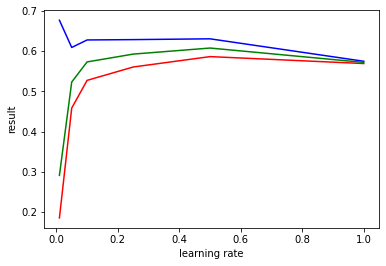

In [96]:
#module tuning for learning rate using validation 
learning_rates = [1,0.5,0.25, 0.1, 0.05,0.01]
precision_result = []
recall_result = []
f1_result = []
for eta in learning_rates:
   model = GradientBoostingClassifier(learning_rate=eta,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   train_pred = model.predict(xtrain_sampled)
   y_pred = model.predict(xval)
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, precision_result, 'b', label="precision")
line2, = plt.plot(learning_rates, recall_result, 'r', label="recall")
line3, = plt.plot(learning_rates, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('learning rate')
plt.show()

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


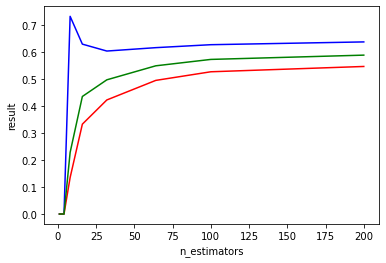

In [97]:
#module tuning for N_estimators using validation 
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
precision_result = []
recall_result = []
f1_result = []
for estimator in n_estimators:
   model = GradientBoostingClassifier(learning_rate=0.1,n_estimators=estimator,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   train_pred = model.predict(xtrain_sampled)
   y_pred = model.predict(xval)
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, precision_result, 'b', label="precision")
line2, = plt.plot(n_estimators, recall_result, 'r', label="recall")
line3, = plt.plot(n_estimators, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('n_estimators')
plt.show()

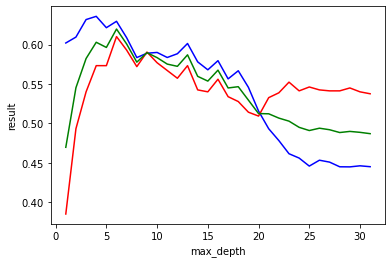

In [169]:
#module tuning for max_depths using validation 
max_depths = np.arange(1, 32, 1)
max_depths
precision_result = []
recall_result = []
f1_result = []
for max_depth in max_depths:
   model = GradientBoostingClassifier(learning_rate=0.1,n_estimators=150,max_depth=max_depth,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   train_pred = model.predict(xtrain_sampled)
   y_pred = model.predict(xval)
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, precision_result, 'b', label="precision")
line2, = plt.plot(max_depths, recall_result, 'r', label="recall")
line3, = plt.plot(max_depths, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('max_depth')
plt.show()

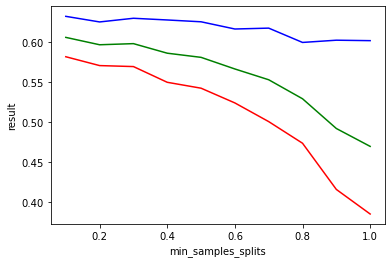

In [170]:
#moduel tuning for min_samples_splits using validation 
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
precision_result = []
recall_result = []
f1_result = []
for min_samples_split in min_samples_splits:
   model = GradientBoostingClassifier(learning_rate=0.1,n_estimators=150,max_depth=6,min_samples_split=min_samples_split,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   train_pred = model.predict(xtrain_sampled)
   y_pred = model.predict(xval)
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, precision_result, 'b', label="precision")
line2, = plt.plot(min_samples_splits, recall_result, 'r', label="recall")
line3, = plt.plot(min_samples_splits, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('min_samples_splits')
plt.show()

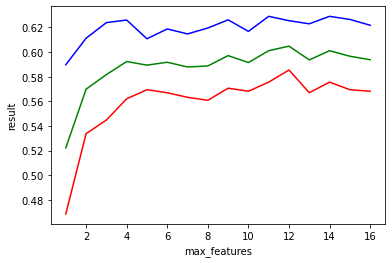

In [171]:
#module tuning for max_features using validation 
max_features = list(range(1,train_data.shape[1]))
precision_result = []
recall_result = []
f1_result = []
for max_feature in max_features:
#  model = GradientBoostingClassifier(learning_rate=0.2,n_estimators=60,max_depth=4,min_samples_split=0.2,max_features=max_feature)
   model = GradientBoostingClassifier(learning_rate=0.1,n_estimators=150,max_depth=6,min_samples_split=0.1,max_features=max_feature,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   train_pred = model.predict(xtrain_sampled)
   y_pred = model.predict(xval)
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, precision_result, 'b', label="precision")
line2, = plt.plot(max_features, recall_result, 'r', label="recall")
line3, = plt.plot(max_features, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('max_features')
plt.show()

# Apply new parameters to GBC model

In [233]:
gbc3 = GradientBoostingClassifier(learning_rate=0.05,n_estimators=80,max_depth=6,min_samples_split=0.1,max_features=11,random_state=5101)
gbc3.fit(xtrain_SMOTE, ytrain_SMOTE)

GradientBoostingClassifier(learning_rate=0.05, max_depth=6, max_features=11,
                           min_samples_split=0.1, n_estimators=80,
                           random_state=5101)

In [236]:
new_proba = gbc3.predict_proba(xtest)
new_prediction = (new_proba[:, 1] >= 0.4).astype('int')

In [237]:
print('precision:', precision_score(ytest, new_prediction))
print('recall:', recall_score(ytest, new_prediction))
print('f1:', f1_score(ytest, new_prediction))
print('accuracy',accuracy_score(ytest, new_prediction))

precision: 0.4603358425014476
recall: 0.7514177693761814
f1: 0.570915619389587
accuracy 0.8678535884109255


# 2.3 Decision Tree Classifier

# 2.3.1 train on unsampled data

In [152]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=5101)
dt.fit(xtrain, ytrain)

DecisionTreeClassifier(random_state=5101)

In [153]:
new_proba = dt.predict_proba(xtest)
new_prediction = (new_proba[:, 1] >= 0.4).astype('int')

In [154]:
print('precision:', precision_score(ytest, new_prediction))
print('recall:', recall_score(ytest, new_prediction))
print('f1:', f1_score(ytest, new_prediction))
print('accuracy',accuracy_score(ytest, new_prediction))

precision: 0.2793354101765317
recall: 0.5085066162570888
f1: 0.36058981233243964
accuracy 0.7890080725422979


# 2.3.2 train on Downsampled Data

In [143]:
dt2 = DecisionTreeClassifier(random_state=5101)
dt2.fit(xtrain_sampled, ytrain_sampled)

DecisionTreeClassifier(random_state=5101)

In [144]:
new_proba = dt2.predict_proba(xtest)
new_prediction = (new_proba[:, 1] >= 0.4).astype('int')

In [142]:
print('precision:', precision_score(ytest, new_prediction))
print('recall:', recall_score(ytest, new_prediction))
print('f1:', f1_score(ytest, new_prediction))
print('accuracy',accuracy_score(ytest, new_prediction))

precision: 0.22378199834847234
recall: 0.5122873345935728
f1: 0.31149425287356325
accuracy 0.7350436801946256


# 2.3.3 train on SMOTE data

In [155]:
dt3 = DecisionTreeClassifier(random_state=5101)
dt3.fit(xtrain_SMOTE, ytrain_SMOTE)

DecisionTreeClassifier(random_state=5101)

In [156]:
new_proba = dt3.predict_proba(xtest)
new_prediction = (new_proba[:, 1] >= 0.4).astype('int')

In [157]:
print('precision:', precision_score(ytest, new_prediction))
print('recall:', recall_score(ytest, new_prediction))
print('f1:', f1_score(ytest, new_prediction))
print('accuracy',accuracy_score(ytest, new_prediction))

precision: 0.23909171861086376
recall: 0.5075614366729678
f1: 0.32506053268765134
accuracy 0.7534004202145306


# 2.3.4 parameter tuning using downsampled dat

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


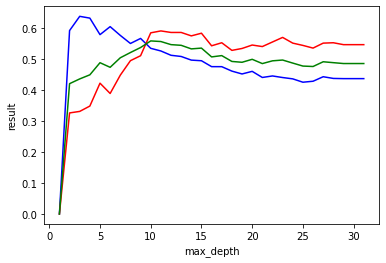

In [158]:
#moudle tuning for max_depths using validation
max_depths = np.arange(1, 32, 1)
max_depths
precision_result = []
recall_result = []
f1_result = []
for max_depth in max_depths:
   model = DecisionTreeClassifier(max_depth=max_depth,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   train_pred = model.predict(xtrain_sampled)
   y_pred = model.predict(xval)
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, precision_result, 'b', label="precision")
line2, = plt.plot(max_depths, recall_result, 'r', label="recall")
line3, = plt.plot(max_depths, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('max_depth')
plt.show()

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


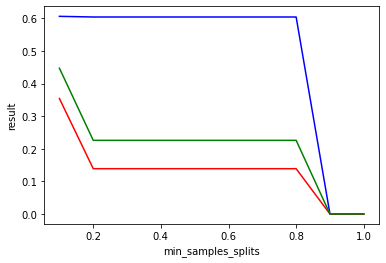

In [159]:
#moudle tuning for min_samples_splits using validation
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
precision_result = []
recall_result = []
f1_result = []
for min_samples_split in min_samples_splits:
   model = DecisionTreeClassifier(max_depth=10,min_samples_split=min_samples_split,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   train_pred = model.predict(xtrain_sampled)
   y_pred = model.predict(xval)
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, precision_result, 'b', label="precision")
line2, = plt.plot(min_samples_splits, recall_result, 'r', label="recall")
line3, = plt.plot(min_samples_splits, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('min_samples_splits')
plt.show()

In [ ]:
#moudle tuning for min_samples_leafs using validation
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
precision_result = []
recall_result = []
f1_result = []
for min_samples_leaf in min_samples_leafs:
   model = DecisionTreeClassifier(max_depth=10,min_samples_split=0.1,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   train_pred = model.predict(xtrain_sampled)
   y_pred = model.predict(xval)
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, precision_result, 'b', label="precision")
line2, = plt.plot(min_samples_leafs, recall_result, 'r', label="recall")
line3, = plt.plot(min_samples_leafs, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('min_samples_leafs')
plt.show()

this para not cause any influence.

# Apply new parameters to DCT model

In [272]:
dt2 = DecisionTreeClassifier(max_depth=10,min_samples_split=0.1,random_state=5101)
dt2.fit(xtrain_sampled, ytrain_sampled)

DecisionTreeClassifier(max_depth=10, min_samples_split=0.1, random_state=5101)

In [273]:
new_proba = dt2.predict_proba(xtest)
new_prediction = (new_proba[:, 1] >= 0.4).astype('int')

In [274]:
print('precision:', precision_score(ytest, new_prediction))
print('recall:', recall_score(ytest, new_prediction))
print('f1:', f1_score(ytest, new_prediction))
print('accuracy',accuracy_score(ytest, new_prediction))

precision: 0.4614797864225782
recall: 0.5718336483931947
f1: 0.5107640354579992
accuracy 0.8718345681742784
